# Проект Рекомендации товаров

**Цель проекта** - разработать алгоритм, который для каждого предложенного в тестовой выборке товара подберет 5 рекомендаций похожих товаров.   

Качество работы алгоритма будет оцениваться следующим способом.  
Каждый товар в тестовой выборке размечен экспертами - они подобрали для него 1 идеальную рекомендацию. Разработанный алгоритм должен подбирать 5 рекомендаций так, чтобы в них попал товар, выбранный экспертами. По каждому набору рекомендаций будет рассчитана метрика accuracy@5. Если рекомендация, отмеченная экспертами, попала в 5 рекомендаций, выбранных алгоритмом, accuracy для данного наблюдения будет равно 1, в противном случае - 0. Итоговое значение метрики - среднее по всем товарам в тестовой выборке. Желаемое значение accuracy@5 - не менее 2/3 или, иначе говоря, 66%. Данная цифра является стандартом для работы подобных алгоритмов.

**Описание данных**  
***Выборка всех товаров*** - файлы full_base.csv (полная таблица, содержащая все товары) и base.csv (сокращенная версия full_base, содержащая только часть товаров)  
*Id* - уникальный идентификатор товара  
*Признаки с номерами от 0 до 71* - анонимизированные характеристики товара, выраженные числами. Какая именно характеристика скрывается за тем или иным признаком - неизвестно  

***Тренировочная выборка*** - файлы full_train.csv и train.csv - по аналогии с base, полная и сокращенная версии тренировочной выборки  
*Id* - уникальный идентификатор товара  
*Признаки с номерами от 0 до 71* - анонимизированные характеристики товара, выраженные числами. Какая именно характеристика скрывается за тем или иным признаком - неизвестно  
*Target* - рекомендованный товар для товара Id, выбранный экспертами  

***Тестовая выборка*** - файлы validation.csv и full_validation.csv - по аналогии с base, полная и сокращенная версии тестовой выборки  
*Id* - уникальный идентификатор товара  
*Признаки с номерами от 0 до 71* - анонимизированные характеристики товара, выраженные числами. Какая именно характеристика скрывается за тем или иным признаком - неизвестно  

***Правильные ответы для тестовой выборки*** - файлы validation_answer.csv и full_validation_answer.csv - по аналогии с base, полная и сокращенная версии правильных ответов для тестовой выборки  
*Id* - уникальный идентификатор товара  
*Expected* - рекомендованный товар для товара Id, выбранный экспертами  

Важный момент, касающийся датасетов, заключается в том, все товары, которые есть в тренировочной и тестовой выборках, присутствуют также и в соответствующих им base. При этом сокращенная base является частью полной base (какой именно - узнаем в процессе исследования). Таким образом, в полной base есть все товары из всех выборок.

**План работы**  
1. Знакомство с данными. Открытие файлов с данными, вывод общей информации о датасетах, работа с пропусками и дубликатами. На этом этапе также проведем исследовательский анализ данных.  
2. Разработка алгоритма поиска рекомендаций. Инициализация алгоритма из библиотеки FAISS, подбор наилучших гиперпараметров, тестирование алгоритма на тренировочной выборке.  
3. Финализация решения. Применение разработанного алгоритма на полной тестовой выборке, расчет итогового значения accuracy@5.  

Согласно описанию данных, каждая выборка представлена у нас в двух версиях - полной и сокращенной. Ожидается, что полные версии содержат очень большое количество наблюдений, в результате чего работа с ними займет много времени и вычислительных ресурсов. По этой причине разработка и подбор оптимальных параметров алгоритма будут произведены на сокращенных версиях датасетов, а финальное решение будет протестировано на полных версиях.

In [ ]:
#Установка необходимых библиотек
!pip -q install faiss-cpu # загрузка библиотеки faiss

In [ ]:
# импорты необходимых библиотек
import pandas as pd
import faiss
import gc
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns
from sklearn.preprocessing import (StandardScaler,
                                   MinMaxScaler,
                                   RobustScaler)
import time

## 1. Знакомство с данными

### Загрузка и открытие датасетов

Откроем файлы и посмотрим на данные. Сначала base.

In [ ]:
base = pd.read_csv('/content/drive/MyDrive/base.csv')
full_base = pd.read_csv('/content/drive/MyDrive/full_base.csv')
print('Сокращенная base')
base.info()
display(base.head())
print()
print('Полная base')
full_base.info()
display(full_base.head())

Сокращенная base
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291813 entries, 0 to 291812
Data columns (total 73 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Id      291813 non-null  object 
 1   0       291813 non-null  float64
 2   1       291813 non-null  float64
 3   2       291813 non-null  float64
 4   3       291813 non-null  float64
 5   4       291813 non-null  float64
 6   5       291813 non-null  float64
 7   6       291813 non-null  float64
 8   7       291813 non-null  float64
 9   8       291813 non-null  float64
 10  9       291813 non-null  float64
 11  10      291813 non-null  float64
 12  11      291813 non-null  float64
 13  12      291813 non-null  float64
 14  13      291813 non-null  float64
 15  14      291813 non-null  float64
 16  15      291813 non-null  float64
 17  16      291813 non-null  float64
 18  17      291813 non-null  float64
 19  18      291813 non-null  float64
 20  19      291813 non-null  float6

,Id,0,1,2,3,4,5,6,7,8,...,62,63,64,65,66,67,68,69,70,71
0,4207931-base,-43.946243,15.364378,17.515854,-132.31146,157.064420,-4.069252,-340.630860,-57.550140,128.398220,...,-71.927170,30.711966,-90.190475,-24.931271,66.972534,106.346634,-44.270622,155.98834,-1074.464888,-25.066608
1,2710972-base,-73.004890,4.923342,-19.750746,-136.52908,99.907170,-70.709110,-567.401996,-128.890150,109.914986,...,-109.044660,20.916021,-171.201390,-110.596844,67.730100,8.909615,-9.470253,133.29536,-545.897014,-72.913230
2,1371460-base,-85.565570,-0.493598,-48.374817,-157.98502,96.809510,-81.710210,-22.297688,79.768670,124.357086,...,-58.821650,41.369606,-132.934500,-43.016839,67.871925,141.778240,69.048520,111.72038,-1111.038833,-23.087206
3,3438601-base,-105.564090,15.393871,-46.223934,-158.11488,79.514114,-48.944480,-93.713010,38.581398,123.397960,...,-87.907290,-58.806870,-147.794800,-155.830237,68.974754,21.397510,126.098785,139.73320,-1282.707248,-74.527940
4,422798-base,-74.638880,11.315012,-40.204174,-161.76430,50.507114,-80.775560,-640.923467,65.225000,122.344940,...,-30.002094,53.642930,-149.823230,176.921371,69.473280,-43.395180,-58.947716,133.84064,-1074.464888,-1.164146



Полная base
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2918139 entries, 0 to 2918138
Data columns (total 73 columns):
 #   Column  Dtype  
---  ------  -----  
 0   Id      object 
 1   0       float64
 2   1       float64
 3   2       float64
 4   3       float64
 5   4       float64
 6   5       float64
 7   6       float64
 8   7       float64
 9   8       float64
 10  9       float64
 11  10      float64
 12  11      float64
 13  12      float64
 14  13      float64
 15  14      float64
 16  15      float64
 17  16      float64
 18  17      float64
 19  18      float64
 20  19      float64
 21  20      float64
 22  21      float64
 23  22      float64
 24  23      float64
 25  24      float64
 26  25      float64
 27  26      float64
 28  27      float64
 29  28      float64
 30  29      float64
 31  30      float64
 32  31      float64
 33  32      float64
 34  33      float64
 35  34      float64
 36  35      float64
 37  36      float64
 38  37      float64
 39  38      

,Id,0,1,2,3,4,5,6,7,8,...,62,63,64,65,66,67,68,69,70,71
0,0-base,-115.083890,11.152912,-64.426760,-118.88089,216.482440,-104.698060,-469.070588,44.348083,120.915344,...,-42.808693,38.800827,-151.76218,-74.389090,63.66634,-4.703861,92.933610,115.269190,-112.756640,-60.830353
1,1-base,-34.562202,13.332763,-69.787610,-166.53348,57.680607,-86.098370,-85.076666,-35.637436,119.718636,...,-117.767525,41.100000,-157.82940,-94.446806,68.20211,24.346846,179.937930,116.834000,-84.888941,-59.524610
2,2-base,-54.233746,6.379371,-29.210136,-133.41383,150.895830,-99.435326,52.554795,62.381706,128.951450,...,-76.397800,46.011803,-207.14442,127.325570,65.56618,66.325680,81.073490,116.594154,-1074.464888,-32.527206
3,3-base,-87.520130,4.037884,-87.803030,-185.06763,76.369540,-58.985165,-383.182845,-33.611237,122.031910,...,-70.647940,-6.358921,-147.20105,-37.692750,66.20289,-20.566910,137.206940,117.474100,-1074.464888,-72.915490
4,4-base,-72.743850,6.522049,43.671265,-140.60803,5.820023,-112.074080,-397.711282,45.182500,122.167180,...,-57.199104,56.642403,-159.35184,85.944724,66.76632,-2.505783,65.315285,135.051590,-1074.464888,0.319401


В полной base 2 918 139 строк, сокращенная содержит 10% от полной. Содержание датасетов на первый взгляд соответствует описанию данных, пропуски отсутствуют. Взглянем на train.

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/train.csv')
full_train = pd.read_csv('/content/drive/MyDrive/full_train.csv')
print('Сокращенная train')
train.info()
display(train.head())
print()
print('Полная train')
full_train.info()
display(full_train.head())

Сокращенная train
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Data columns (total 74 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      9999 non-null   object 
 1   0       9999 non-null   float64
 2   1       9999 non-null   float64
 3   2       9999 non-null   float64
 4   3       9999 non-null   float64
 5   4       9999 non-null   float64
 6   5       9999 non-null   float64
 7   6       9999 non-null   float64
 8   7       9999 non-null   float64
 9   8       9999 non-null   float64
 10  9       9999 non-null   float64
 11  10      9999 non-null   float64
 12  11      9999 non-null   float64
 13  12      9999 non-null   float64
 14  13      9999 non-null   float64
 15  14      9999 non-null   float64
 16  15      9999 non-null   float64
 17  16      9999 non-null   float64
 18  17      9999 non-null   float64
 19  18      9999 non-null   float64
 20  19      9999 non-null   float64
 21  20      9999 non-nu

,Id,0,1,2,3,4,5,6,7,8,...,63,64,65,66,67,68,69,70,71,Target
0,109249-query,-24.021454,3.122524,-80.947525,-112.329994,191.090180,-66.903130,-759.626065,-75.284454,120.55149,...,-24.601670,-167.760770,133.678516,68.184600,26.317545,11.938202,148.549320,-778.563381,-46.877750,66971-base
1,34137-query,-82.033580,8.115866,-8.793022,-182.972100,56.645336,-52.597610,-55.720337,130.059250,129.38335,...,54.448433,-120.894806,-12.292085,66.608116,-27.997612,10.091335,95.809265,-1022.691531,-88.564705,1433819-base
2,136121-query,-75.719640,-0.223386,-86.186130,-162.064060,114.320114,-53.394600,-117.261013,-24.857851,124.80780,...,-5.609123,-93.029880,-80.997871,63.733383,11.378683,62.932007,130.975390,-1074.464888,-74.861176,290133-base
3,105191-query,-56.580620,5.093593,-46.943110,-149.039120,112.436430,-76.820510,-324.995645,-32.833107,119.47865,...,21.624313,-158.880370,179.597294,69.891360,-33.804955,233.914610,122.868546,-1074.464888,-93.775375,1270048-base
4,63983-query,-52.725650,9.027046,-92.829650,-113.111010,134.124970,-42.423073,-759.626065,8.261169,119.49023,...,13.807772,-208.650040,41.742014,66.522420,41.362930,162.723050,111.261310,-151.162805,-33.831450,168591-base



Полная train
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 74 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Id      100000 non-null  object 
 1   0       100000 non-null  float64
 2   1       100000 non-null  float64
 3   2       100000 non-null  float64
 4   3       100000 non-null  float64
 5   4       100000 non-null  float64
 6   5       100000 non-null  float64
 7   6       100000 non-null  float64
 8   7       100000 non-null  float64
 9   8       100000 non-null  float64
 10  9       100000 non-null  float64
 11  10      100000 non-null  float64
 12  11      100000 non-null  float64
 13  12      100000 non-null  float64
 14  13      100000 non-null  float64
 15  14      100000 non-null  float64
 16  15      100000 non-null  float64
 17  16      100000 non-null  float64
 18  17      100000 non-null  float64
 19  18      100000 non-null  float64
 20  19      100000 non-null  float64
 2

,Id,0,1,2,3,4,5,6,7,8,...,63,64,65,66,67,68,69,70,71,Target
0,0-query,-53.882748,17.971436,-42.117104,-183.93668,187.517490,-87.144930,-347.360606,38.307602,109.085560,...,70.107360,-155.80257,-101.965943,65.903790,34.457500,62.642094,134.763600,-415.750254,-25.958572,675816-base
1,1-query,-87.776370,6.806268,-32.054546,-177.26039,120.803330,-83.810590,-94.572749,-78.433090,124.915900,...,4.669178,-151.69771,-1.638704,68.170876,25.096191,89.974976,130.589630,-1035.092211,-51.276833,366656-base
2,2-query,-49.979565,3.841486,-116.118590,-180.40198,190.128430,-50.837620,26.943937,-30.447489,125.771164,...,78.039764,-169.14620,82.144186,66.008220,18.400496,212.409730,121.931470,-1074.464888,-22.547178,1447819-base
3,3-query,-47.810562,9.086598,-115.401695,-121.01136,94.652840,-109.255410,-775.150134,79.186520,124.003100,...,44.515266,-145.41675,93.990981,64.131350,106.061920,83.178760,118.277725,-1074.464888,-19.902788,1472602-base
4,4-query,-79.632126,14.442886,-58.903397,-147.05254,57.127068,-16.239529,-321.317964,45.984676,125.941284,...,45.028910,-196.09207,-117.626337,66.926220,42.456170,77.621765,92.479930,-1074.464888,-21.149351,717819-base


В полной train 100 000 наблюдений, в сокращенной - 10% от полной. Типы данных соответствуют описанию, пропуски не видны. Откроем validation.

In [ ]:
validation = pd.read_csv('/content/drive/MyDrive/validation.csv')
full_validation = pd.read_csv('/content/drive/MyDrive/full_validation.csv')
print('Сокращенная validation')
validation.info()
display(validation.head())
print()
print('Полная validation')
full_validation.info()
display(full_validation.head())

Сокращенная validation
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 73 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      10000 non-null  object 
 1   0       10000 non-null  float64
 2   1       10000 non-null  float64
 3   2       10000 non-null  float64
 4   3       10000 non-null  float64
 5   4       10000 non-null  float64
 6   5       10000 non-null  float64
 7   6       10000 non-null  float64
 8   7       10000 non-null  float64
 9   8       10000 non-null  float64
 10  9       10000 non-null  float64
 11  10      10000 non-null  float64
 12  11      10000 non-null  float64
 13  12      10000 non-null  float64
 14  13      10000 non-null  float64
 15  14      10000 non-null  float64
 16  15      10000 non-null  float64
 17  16      10000 non-null  float64
 18  17      10000 non-null  float64
 19  18      10000 non-null  float64
 20  19      10000 non-null  float64
 21  20      10000

,Id,0,1,2,3,4,5,6,7,8,...,62,63,64,65,66,67,68,69,70,71
0,196680-query,-59.383420,8.563436,-28.203072,-134.22534,82.73661,-150.572170,-129.178969,23.670555,125.66636,...,-103.481630,79.564530,-120.31357,54.218155,68.50073,32.681908,84.19686,136.412960,-1074.464888,-21.233612
1,134615-query,-103.912150,9.742726,-15.209915,-116.37310,137.69880,-85.530075,-776.123158,44.481530,114.67121,...,-51.193770,49.299644,-101.89454,105.560548,67.80104,13.633057,108.05138,111.864456,-841.022331,-76.567980
2,82675-query,-117.923280,-3.504554,-64.299390,-155.18713,156.82137,-34.082264,-537.423653,54.078613,121.97396,...,-115.176155,48.636130,-132.17967,-0.988696,68.11125,107.065216,134.61765,134.080000,27.773269,-32.401714
3,162076-query,-90.880554,4.888542,-39.647797,-131.75010,62.36212,-105.593270,-347.132493,-83.351750,133.91331,...,-112.293790,54.884007,-177.56935,-116.374997,67.88766,136.893980,124.89447,117.707750,-566.343980,-90.905556
4,23069-query,-66.946740,10.562773,-73.781830,-149.39787,2.93866,-51.288853,-587.189361,-2.764402,126.56105,...,-116.440605,47.279976,-162.65400,107.409409,67.78526,-60.976490,142.68571,82.264300,-345.340457,-48.572525



Полная validation
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 73 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Id      100000 non-null  object 
 1   0       100000 non-null  float64
 2   1       100000 non-null  float64
 3   2       100000 non-null  float64
 4   3       100000 non-null  float64
 5   4       100000 non-null  float64
 6   5       100000 non-null  float64
 7   6       100000 non-null  float64
 8   7       100000 non-null  float64
 9   8       100000 non-null  float64
 10  9       100000 non-null  float64
 11  10      100000 non-null  float64
 12  11      100000 non-null  float64
 13  12      100000 non-null  float64
 14  13      100000 non-null  float64
 15  14      100000 non-null  float64
 16  15      100000 non-null  float64
 17  16      100000 non-null  float64
 18  17      100000 non-null  float64
 19  18      100000 non-null  float64
 20  19      100000 non-null  float

,Id,0,1,2,3,4,5,6,7,8,...,62,63,64,65,66,67,68,69,70,71
0,100000-query,-57.372734,3.597752,-13.213642,-125.92679,110.74594,-81.279594,-461.003172,139.815720,112.880980,...,-75.51302,52.830902,-143.43945,59.051935,69.28224,61.927513,111.59253,115.140656,-1099.130485,-117.079360
1,100001-query,-53.758705,12.790300,-43.268543,-134.41762,114.44991,-90.520130,-759.626065,63.995087,127.117905,...,-79.44183,29.185436,-168.60590,-82.872443,70.76560,-65.975950,97.07716,123.391640,-744.442332,-25.009320
2,100002-query,-64.175095,-3.980927,-7.679249,-170.16093,96.44616,-62.377740,-759.626065,87.477554,131.270110,...,-134.79541,37.368730,-159.66231,-119.232725,67.71044,86.002060,137.63641,141.081630,-294.052271,-70.969604
3,100003-query,-99.286860,16.123936,9.837166,-148.06044,83.69708,-133.729720,58.576403,-19.046660,115.042404,...,-77.23611,44.100494,-132.53012,-106.318982,70.88396,23.577892,133.18396,143.252940,-799.363667,-89.392670
4,100004-query,-79.532920,-0.364173,-16.027431,-170.88495,165.45392,-28.291668,33.931936,34.411217,128.903980,...,-123.77025,45.635944,-134.25893,13.735359,70.61763,15.332115,154.56812,101.700640,-1171.892332,-125.307890


Количество аналогично тренировочной выборке - 100 000 в полном датасете, 10% - в сокращенном. Тип данных соответствует описанию, пропусков нет. Осталась validation_answer.

In [ ]:
validation_answer = pd.read_csv('/content/drive/MyDrive/validation_answer.csv')
full_validation_answer = pd.read_csv('/content/drive/MyDrive/full_validation_answer.csv')
print('Сокращенная validation_answer')
validation_answer.info()
display(validation_answer.head())
print()
print('Полная validation_answer')
full_validation_answer.info()
display(full_validation_answer.head())

Сокращенная validation_answer
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        10000 non-null  object
 1   Expected  10000 non-null  object
dtypes: object(2)
memory usage: 156.4+ KB


,Id,Expected
0,196680-query,1087368-base
1,134615-query,849674-base
2,82675-query,4183486-base
3,162076-query,2879258-base
4,23069-query,615229-base



Полная validation_answer
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Id        100000 non-null  object
 1   Expected  100000 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB


,Id,Expected
0,100000-query,2676668-base
1,100001-query,91606-base
2,100002-query,472256-base
3,100003-query,3168654-base
4,100004-query,75484-base


Здесь также 100 000 в полной и 10% от полной в сокращенной. На первый взгляд все корректно, пропусков нет.  

Проведем предобработку.

### Обработка пропусков и дубликатов

При открытии датасетов мы не увидели пропусков. Но так как количество столбцов большое лучше проверить.

In [ ]:
data = ['base', 'full_base', 'train', 'full_train', 'validation', 'full_validation', 'validation_answer', 'full_validation_answer']
for d in data:
  print(f'Количество пропусков в {d}:', globals()[d].isna().sum()[1])

Количество пропусков в base: 0


<ipython-input-7-2294ca6a6f63>:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'Количество пропусков в {d}:', globals()[d].isna().sum()[1])


Количество пропусков в full_base: 0
Количество пропусков в train: 0
Количество пропусков в full_train: 0
Количество пропусков в validation: 0
Количество пропусков в full_validation: 0
Количество пропусков в validation_answer: 0
Количество пропусков в full_validation_answer: 0


Пропуски отсутствуют. Теперь проверим наличие полных дублей.

In [ ]:
for d in data:
  print(f'Количество полных дублей в {d}:', globals()[d].duplicated().sum())

Количество полных дублей в base: 11278
Количество полных дублей в full_base: 0
Количество полных дублей в train: 243
Количество полных дублей в full_train: 0
Количество полных дублей в validation: 265
Количество полных дублей в full_validation: 0
Количество полных дублей в validation_answer: 265
Количество полных дублей в full_validation_answer: 0


В сокращенных датасетах есть дубликаты, особенно их много в base. Наличие дублей в train и validation исказит итоговую метрику, а в base может привести к тому, что при работе с faiss некорректно сформируются кластеры и рекомендации за счет попадания в кластер одних и тех же элементов. Избавимся от всех дублей.

In [ ]:
data2 = ['base', 'train', 'validation', 'validation_answer']
for d in data2:
  globals()[d] = globals()[d].drop_duplicates()
  print(f'Количество полных дублей в {d}:', globals()[d].duplicated().sum())

Количество полных дублей в base: 0
Количество полных дублей в train: 0
Количество полных дублей в validation: 0
Количество полных дублей в validation_answer: 0


Теперь проверим наличие дублей по Id товара. Нужно убедиться, что в датасетах нет товаров с одинаковыми Id, но разными характеристиками.

In [ ]:
for d in data:
  print(f'Количество дублей по Id в {d}:', globals()[d].duplicated(subset=['Id']).sum())

Количество дублей по Id в base: 0
Количество дублей по Id в full_base: 0
Количество дублей по Id в train: 0
Количество дублей по Id в full_train: 0
Количество дублей по Id в validation: 0
Количество дублей по Id в full_validation: 0
Количество дублей по Id в validation_answer: 0
Количество дублей по Id в full_validation_answer: 0


Дублей по Id нет.  

На текущем этапе уберем Id в индекс датасетов. Для дальнейшего анализа он нам не нужен, а вот при работе с Faiss потребуется именно как индекс.

In [ ]:
data = ['base', 'full_base', 'train', 'full_train', 'validation', 'full_validation', 'validation_answer', 'full_validation_answer']
for d in data:
  globals()[d] = globals()[d].set_index('Id')

Датасеты почищены, Id передан в индекс. Перейдем к исследовательскому анализу.

### Исследовательский анализ

Возможности для исследовательского анализа у нас ограничены. Это связано с тем, что признаки во всех датасетах анонимизированы, в результате чего мы не знаем, какие именно характеристики товаров скрываются за ними.  

Но кое-что оценить мы все же можем. Работать будем с сокращенными выборками, так как именно на них будет разрабатываться и тестироваться алгоритм. Построим распределения значений признаков.

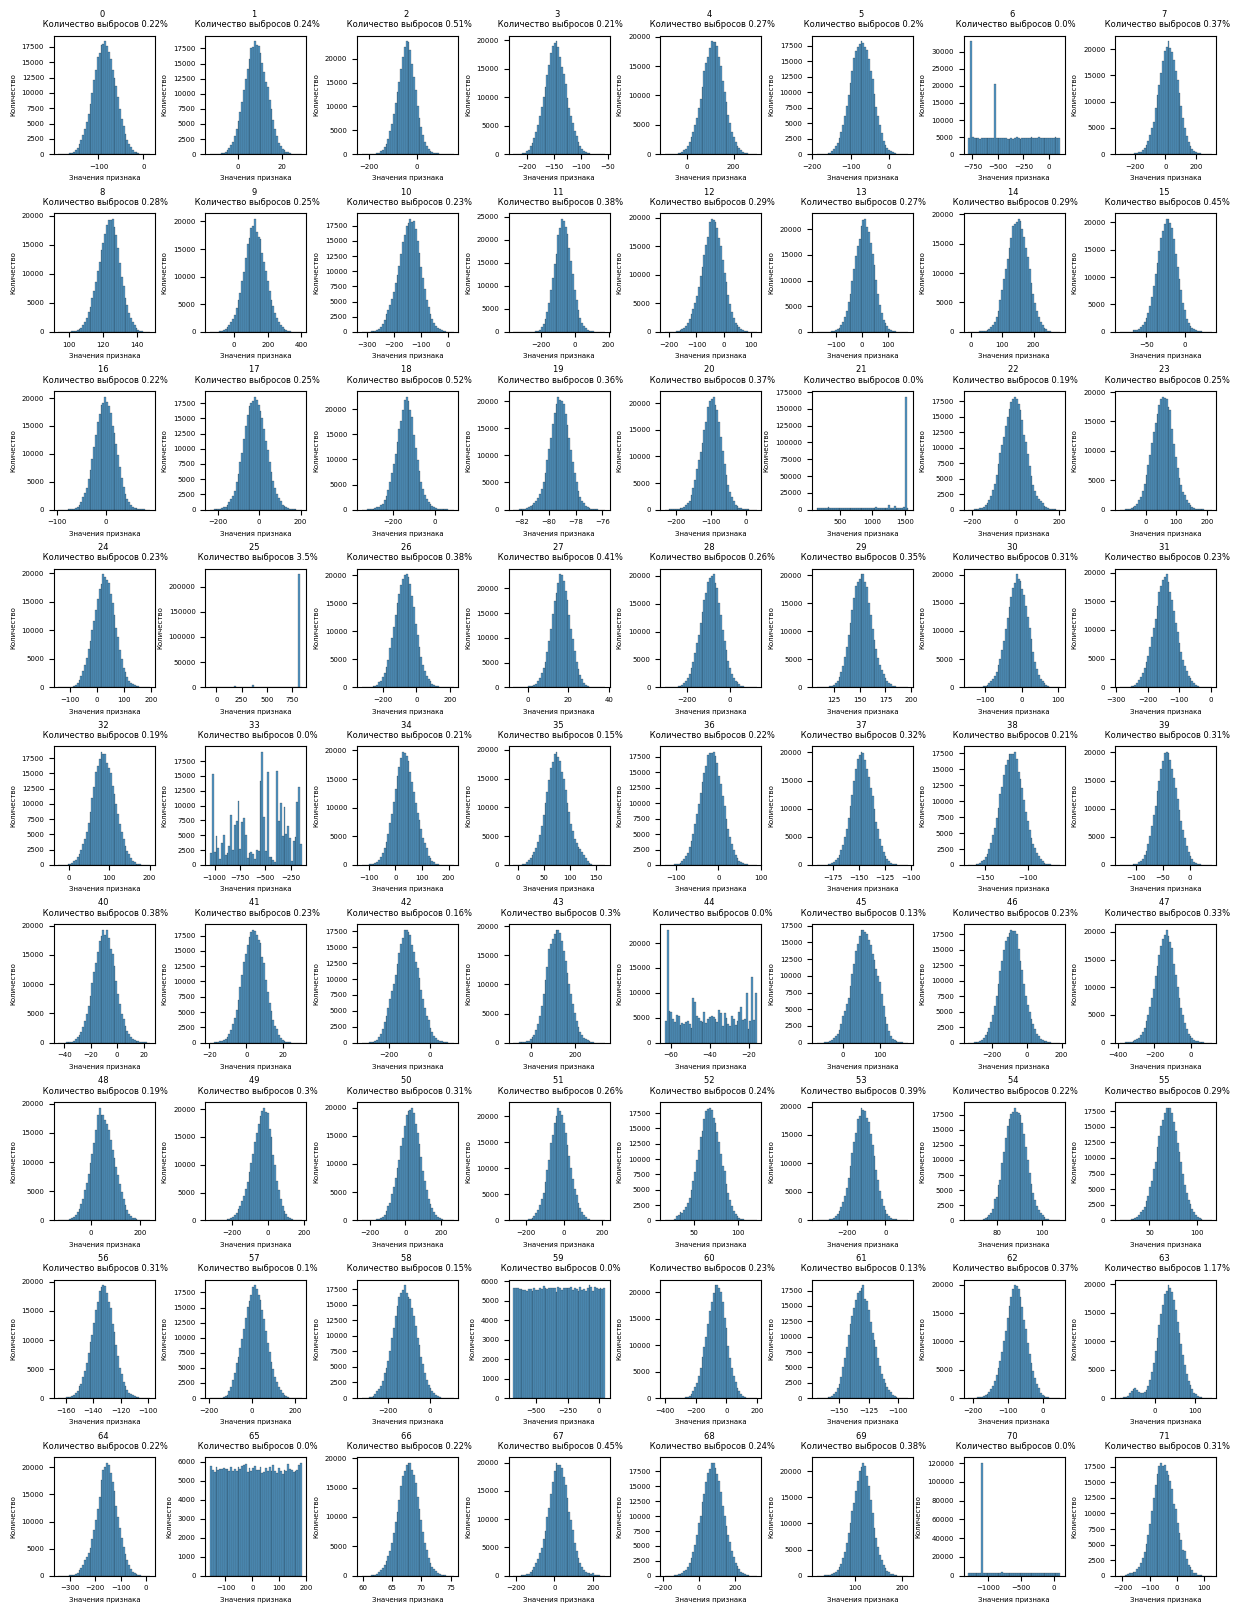

In [ ]:
# При помощи z-оценок находим количество выбросов
z_values = stats.zscore(base)
vybr = []
for col in z_values.columns.to_list():
  vybr.append(round(len(z_values[np.abs(z_values[col]) > 3]) / len(base) * 100, 2))

# строим графики распределений
cols = base.columns.to_list()
i=0
plt.rc('font', size=5)
fig, axes = plt.subplots(nrows=9, ncols=8, figsize=(15,20))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
axe = axes.ravel()
for col, v in zip(cols, vybr):
    sns.histplot(base[col], kde=False, bins=50, ax=axe[i])
    axe[i].set_title(f'{col} \n Количество выбросов {v}%')
    axe[i].set_ylabel('Количество')
    axe[i].set_xlabel('Значения признака')
    i+=1
None

Некоторые признаки (6, 21, 25, 33, 44, 59, 65, 70) имеют распределение, не являющееся нормальным. При отборе признаков для алгоритма в первую очередь следует обратить внимание именно на эти столбцы - возможно, их исключение повысит качество работы алгоритма поиска.    

Наибольшее количество выбросов обнаружено в 25 (3.5%) и 63 (1.17%) признаках. Поскольку мы не знаем, какие характеристики товаров скрываются за признаками датасета, мы не можем определить, являются ли те или иные значения выбросов нереалистичными или нет. Удалять выбросы не будем, поскольку у нас нет уверенности в их нереалистичности, а при их удалении мы сократим пространство поиска рекомендаций, а также рискуем удалить товары, отмеченные экспертами.  

Также, на гистограммах видно, что диапазон значений для разных признаков отличается, а значит, возможно, при разработке алгоритма потребуется использовать стандартизацию.  

Кроме того, в распределениях многих признаков видны отрицательные значения. Учитывая это, а также тот факт, что абсолютно все признаки имеют числовой формат, могу предположить, что значения отдельных признаков - результат кодирования истинных значений, либо рассчитанные коэффициенты, а может быть и то и другое.

Исследовать распределения значений признаков в тренировочной и тестовой выборках мы не будем, так как товары со своими характеристиками в них взяты из base, а значит все значения признаков попадают в соответствующие диапазоны признаков в base.  

Вместо этого проанализируем матрицу корреляции признаков. Нас интересует, содержатся ли в датасете base признаки, которые сильно связаны, либо дублируют друг друга. Так как не все признаки распределены нормально, используем коэффициент Спирмена.


    
<div class="alert alert-success">
<b>хорошо что не удаляешь признаки с ненормальным распределением сразу, а анализируешь ✅:</b> </div>


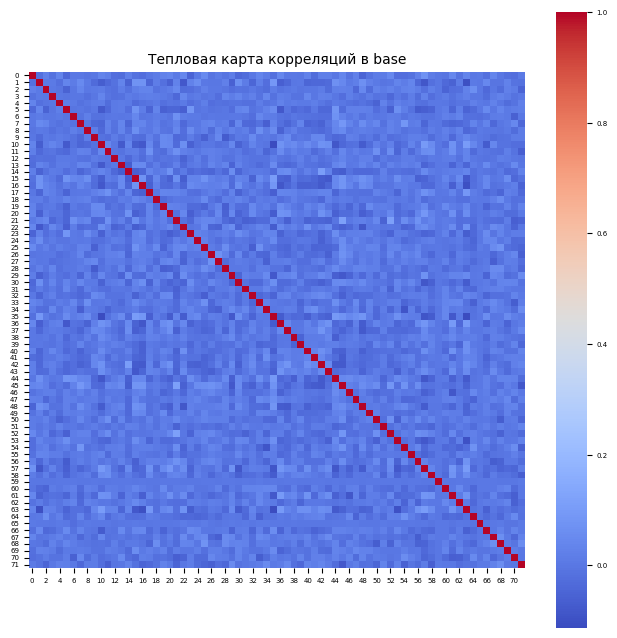

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(base.corr(method='spearman'), cmap='coolwarm', square=True)
plt.title('Тепловая карта корреляций в base', fontsize=10)
None

Все признаки в датасете очень слабо связаны друг с другом, явно дублирующих нет.

### Промежуточный вывод

Все датасеты открыты и изучены.  

Пропуски отсутствуют, однако в сокращенных выборках обнаружены полные дубли. В base дублей особенно много - 11278, в то время как в сокращенной train их 243, а в validation и validation_answer их по 265. дублирующие значения удалены из датасетов.  

Все признаки, отражающие характеристики товаров, имеют числовой формат, причем для некоторых характерно наличие отрицательных значений. Из чего мы сделали вывод, что некоторые признаки могут являться результатом кодирования, либо рассчитанным коэффициентом.  

В каждом из признаков есть небольшое количество (до 1%, а в 2 признаках - 1.17% и 3.5%) выбросов, однако, так как признаки анонимизированы, мы не можем оценить реалистичность данных значений. Принято решение оставить выбросы как есть.  

Диапазоны распределения значений признаков отличаются, а значит, возможно, потребуется прибегнуть к стандартизации.

Корреляционный анализ показал отсутствие значимых связей между признаками датасета.

## 2. Разработка алгоритма поиска рекомендаций

### Базовое решение

Наша задача - разработать алгоритм поиска 5 рекомендаций для каждого товара в датасете validation. Разрабатывать данный алгоритм мы будем при помощи библиотеки Faiss на сокращенных выборках. Самое удачное решение в итоге проверим на полных выборках.  

Качество работы алгоритма будем оцениваться при помощи метрики accuracy@5. Сразу же инициализируем функцию для расчета данной метрики.

In [ ]:
def acc5(targets, idx, base_index):
  acc = 0
  for target, el in zip(targets.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])
  return round(acc / len(idx) * 100, 1)

Инициализируем базовое решение. Обучим faiss на сокращенной base, произведем поиск рекомендаций для товаров из сокращенной train, замерим accuracy@5. Количество кластеров установим на 20, индекс - IVFFlat.

In [ ]:
dims = base.shape[1]
n_cells = 20
quantizer = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)

idx_l2.train(np.ascontiguousarray(base.values).astype('float32'))
idx_l2.add(np.ascontiguousarray(base.values).astype('float32'))

base_index = {k: v for k, v in enumerate(base.index.to_list())}

targets = train["Target"]
train.drop("Target", axis=1, inplace=True)

candidate_number = 5
r, idx = idx_l2.search(np.ascontiguousarray(train.values).astype('float32'), candidate_number)

print('Accuracy@5: ', acc5(targets, idx, base_index))

Accuracy@5:  12.4


Качество базового решения совершенно неудовлетворительное.  

Для повышения значения метрики реализуем следующие шаги:  
1. На этапе исследовательского анализа мы определили, что значения признаков распределены в разных диапазонах. Стандартизируем признаки при помощи скэйлера. Предварительно подберем наиболее подходящий скэйлер;  
2. Предполагаю, что среди характеристик товаров есть более значимые для рекомендаций и менее значимые. Попробуем подобрать оптимальный набор признаков;  
3. Подберем оптимальные гиперпараматры алгоритма поиска;    

Итак, план намечен, приступим к его реализации.

### Выбор скэйлера и стандартизация

Для стандартизации значений признаков в сокращенных base и train используем поочередно 3 скэйлера: StandardScaler, MinMaxScaler и RobustScaler. Для каждого замерим метрику, выберем лучшее решение. Так как в дальнейшем нам предстоит неоднократно обращаться к индексу IVFFlat, обернем его в функцию.

In [ ]:
# Функция для построения IVFFlat
def ivfflat_create(base, n_cells):
  dims = base.shape[1]
  n_cells = n_cells
  quantizer = faiss.IndexFlatL2(dims)
  idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)

  idx_l2.train(np.ascontiguousarray(base).astype('float32'))
  idx_l2.add(np.ascontiguousarray(base).astype('float32'))

  return idx_l2

# Функция для поиска IVFFlat
def ivfflat_search(idx, query, c_number):
  candidate_number = c_number
  return idx.search(np.ascontiguousarray(query).astype('float32'), candidate_number)




In [ ]:
# Перебор скэйлеров
scalers = [StandardScaler(), MinMaxScaler(), RobustScaler()]
accs = []
for s in scalers:
  scaler = s
  base_scalled = scaler.fit_transform(base)
  train_scalled = scaler.transform(train)

  base_index = {k: v for k, v in enumerate(base.index.to_list())}

  idx_l2 = ivfflat_create(base_scalled, 20)

  r, idx = ivfflat_search(idx_l2, train_scalled, 5)

  accs.append(acc5(targets, idx, base_index))

scalers_table = pd.DataFrame(zip(scalers, accs), columns=('Scaler', 'Accuracy@5'))
display(scalers_table)

,Scaler,Accuracy@5
0,StandardScaler(),60.5
1,MinMaxScaler(),20.0
2,RobustScaler(),48.7


Стандартизация очень сильно повысила значение метрики. Наилучший результат дал StandardScaler, далее будем использовать его, создадим соответствующую функцию.

In [ ]:
def scaler(base, query):
  scaler = StandardScaler()
  base_scalled = scaler.fit_transform(base)ё
  train_scalled = scaler.transform(query)
  return base_scalled, train_scalled


### Отбор признаков

Как уже говорилось ранее, мы не знаем, какие именно характеристики товаров скрываются за признаками датасета. Предполагаю, что не все признаки должны иметь значение при составлении рекомендаций, более того, отдельные характеристики могут увести поиск в неверном направлении. Попробуем найти те, при исключении которых метрика повысится.  

На этапе исследовательского анализа мы определили, что ряд признаков распределен ненормально. Проверим, изменится ли метрика при их последовательном исключении.

In [ ]:
cols = ['6', '21', '25', '33', '44', '59', '65', '70']
b_new = base.copy(deep=True)
t_new = train.copy(deep=True)
acc = accs[0]
features = []
f_accs = []
for col in cols:
  b = b_new.drop(col, axis=1)
  t = t_new.drop(col, axis=1)

  base_scalled, train_scalled = scaler(b,t)

  base_index = {k: v for k, v in enumerate(b.index.to_list())}

  idx_l2 = ivfflat_create(base_scalled, 20)

  r, idx = ivfflat_search(idx_l2, train_scalled, 5)

  a = acc5(targets, idx, base_index)

  if a > acc:
    features.append(col)
    f_accs.append(a)
    acc = a
    b_new.drop(col, axis=1, inplace=True)
    t_new.drop(col, axis=1, inplace=True)
  else:
    continue

features_table = pd.DataFrame(zip(features, f_accs), columns=('Удаляемый признак', 'Accuracy@5'))
display(features_table)

,Удаляемый признак,Accuracy@5
0,21,61.1
1,25,64.0
2,33,66.6
3,59,67.6
4,65,68.4
5,70,68.6


Если удалить 6 из 8 ненормально распределенных признаков, метрика значительно вырастает. Проверим на копиях датасетов.

In [ ]:
b = base.copy(deep=True)
t = train.copy(deep=True)

b.drop(columns=['21', '25', '33', '59', '65', '70'],axis=1, inplace=True)
t.drop(columns=['21', '25', '33', '59', '65', '70'],axis=1, inplace=True)

base_scalled, train_scalled = scaler(b,t)

base_index = {k: v for k, v in enumerate(b.index.to_list())}

idx_l2 = ivfflat_create(base_scalled, 20)

r, idx = ivfflat_search(idx_l2, train_scalled, 5)

print('Accuracy@5: ', acc5(targets, idx, base_index))

Accuracy@5:  68.6


Результат подтвердился. Удалим найденные признаки из base и train.

In [ ]:
base.drop(columns=['21', '25', '33', '59', '65', '70'],axis=1, inplace=True)
train.drop(columns=['21', '25', '33', '59', '65', '70'],axis=1, inplace=True)

Дополнительно попробовал перебрать оставшиеся нормально распределенные признаки - выполнение кода заняло много времени, однако превысить метрику не удалось.  

Таким образом остановимся на удалении 6 найденных признаков.

### Подбор гиперпараметров

#### IVFFlat с евклидовым расстоянием

До сих пор для поиска рекомендаций мы использовали индекс IVFFlat с расчетом евклидового расстояния и 20 кластерами. На текущем шаге переберем количество кластеров, а также попробуем использовать другие расстояния и индексы.  

Сначала закончим с евклидовым расстоянием для индекса IVFFlat. Переберем количество кластеров от 10 до 200 включительно с шагом 10. Также замерим время, необходимое на построение индекса и на поиск для каждого количества кластеров.

In [ ]:
ns = []
accs = []
t_create = []
t_search = []
for n in range(10,210,10):
  start = time.perf_counter()
  base_scalled, train_scalled = scaler(base,train)

  base_index = {k: v for k, v in enumerate(base.index.to_list())}

  idx_l2 = ivfflat_create(base_scalled, n)
  create_time = time.perf_counter() - start

  start = time.perf_counter()
  r, idx = ivfflat_search(idx_l2, train_scalled, 5)
  search_time = time.perf_counter() - start

  ns.append(str(n))
  accs.append(acc5(targets, idx, base_index))
  t_create.append(create_time)
  t_search.append(search_time)

e_clusters = pd.DataFrame(zip(ns, accs, t_create, t_search), columns=('Количество кластеров', 'Accuracy@5', 'Время на построение', 'Время на поиск'))

In [ ]:
def grafs(table):
  plt.rc('font', size=6)
  fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10,10))
  plt.subplots_adjust(wspace=0.3, hspace=0.3)
  axes[0].plot(table['Количество кластеров'], table['Accuracy@5'])
  axes[1].plot(table['Количество кластеров'], table['Время на построение'])
  axes[1].plot(table['Количество кластеров'], table['Время на поиск'])
  axes[0].set_title('Значение Accuracy@5 в зависимости от количества кластеров', fontsize=10)
  axes[1].set_title('Временные затраты в зависимости от количества кластеров', fontsize=10)
  axes[1].legend(['Время на построение', 'Время на поиск'])
  axes[0].set_ylabel('Accuracy@5', fontsize=8)
  axes[1].set_ylabel('Временные затраты, с', fontsize=8)
  axes[0].set_xlabel('Количество кластеров', fontsize=8)
  axes[1].set_xlabel('Количество кластеров', fontsize=8)
  plt.show()
  None

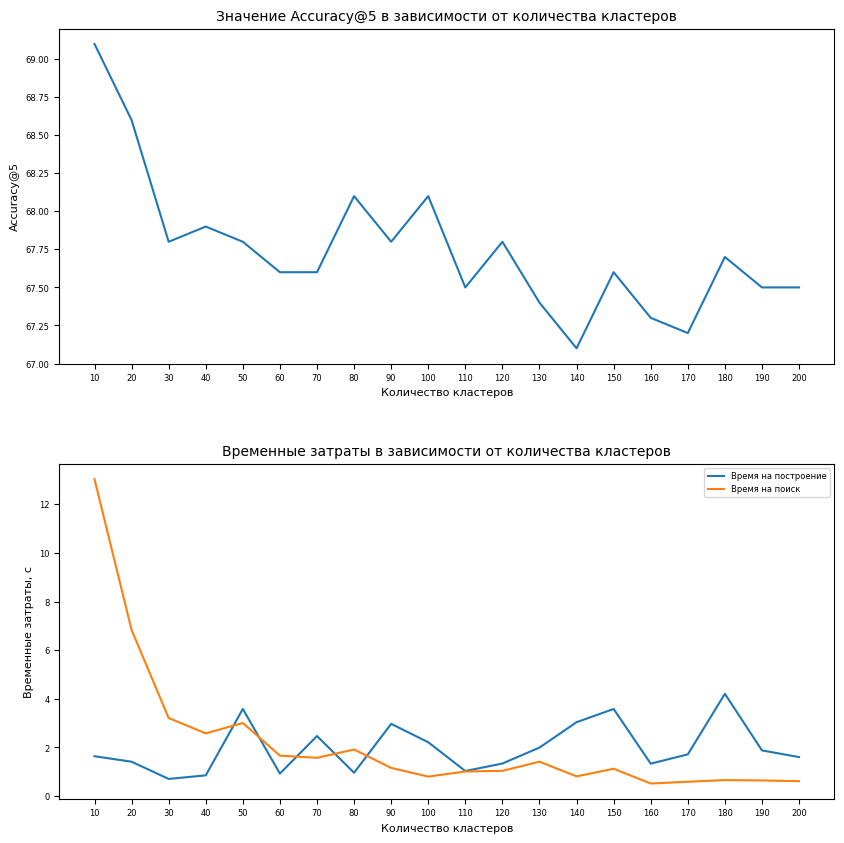

In [ ]:
grafs(e_clusters)

При уменьшении количества кластеров метрика растет, максимальное значение достигнуто на 10 кластерах. Однако, при этом и увеличивается время на работу алгоритма - временные затраты на поиск на 10 и 100 кластеров отличаются очень сильно, при этом изменение в метрике составляет менее 1%. Проверим, на сколько вообще возможно увеличить качество. Добавим результаты на количестве кластеров от 1 до 9 включительно.

In [ ]:
ns2 = []
accs2 = []
t_create2 = []
t_search2 = []
for n in range(1,10,1):
  start = time.perf_counter()
  base_scalled, train_scalled = scaler(base,train)

  base_index = {k: v for k, v in enumerate(base.index.to_list())}

  idx_l2 = ivfflat_create(base_scalled, n)
  create_time = time.perf_counter() - start

  start = time.perf_counter()
  r, idx = ivfflat_search(idx_l2, train_scalled, 5)
  search_time = time.perf_counter() - start

  ns2.append(str(n))
  accs2.append(acc5(targets, idx, base_index))
  t_create2.append(create_time)
  t_search2.append(search_time)


e_clusters2 = pd.DataFrame(zip(ns2, accs2, t_create2, t_search2),
                           columns=('Количество кластеров', 'Accuracy@5', 'Время на построение', 'Время на поиск'))
e = pd.concat([e_clusters2, e_clusters])

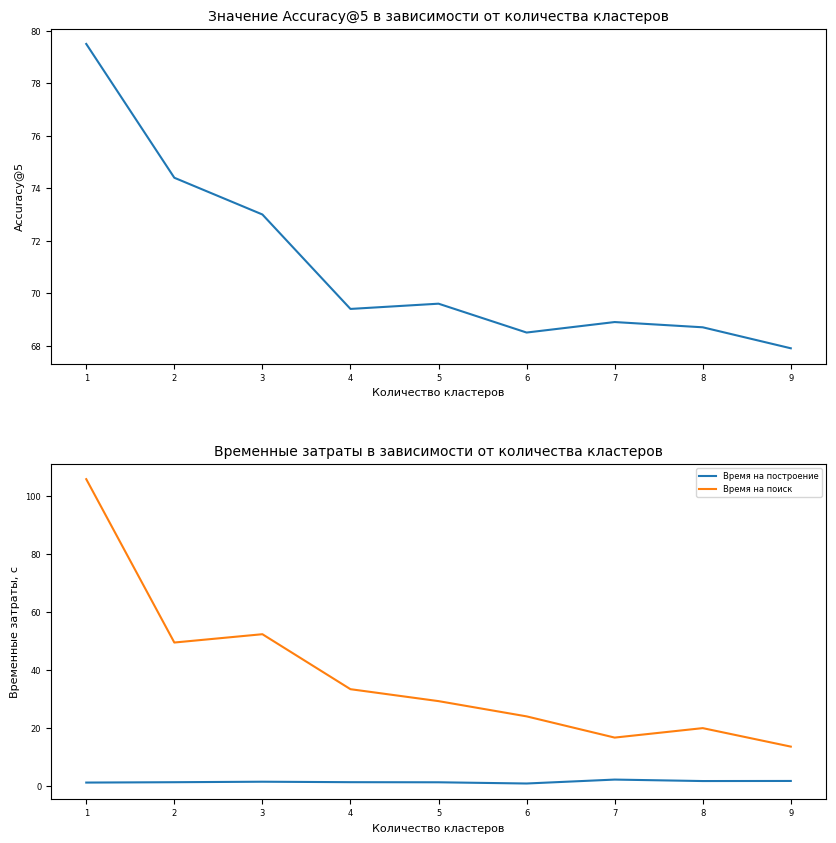

In [ ]:
grafs(e_clusters2)

Максимальная метрика почти в 80% достигнута при 1 кластере, но такой поиск занимает очень большое количество времени, т.к. по своей сути это полный перебор. На большом датасете могут возникнуть проблемы с производительностью.  

Оптимальным с точки зрения соотношения времени и качества предлагаю считать решение со 100 кластерами. Значение метрики здесь превышает 68 и является самым высоким на всем отрезке от 20 кластеров и выше, при этом временные затраты очень низкие.  

Тем не менее, нам неизвестна конечная цель использования разрабатываемого алгоритма. Если он будет использоваться исключительно в исследовательско-аналитических целях, то лучшим решением будет именно 1 кластер, так как метрика тут максимальна. Если же заказчик планирует использовать алгоритм в рекомендательной системе, которая будет работать с клиентами онлайн, то следует использовать решение на 100 кластеров ввиду его оперативности. Поэтому на текущем этапе сохраним оба решения.

In [ ]:
high_m = e[e['Количество кластеров'] == '1']
low_m = e[e['Количество кластеров'] == '100']
results = pd.concat([high_m, low_m]).reset_index(drop=True)
results.insert(0, 'Алгоритм поиска', ['IVFFlat с евклидовым расстоянием', 'IVFFlat с евклидовым расстоянием'])
display(results)

,Алгоритм поиска,Количество кластеров,Accuracy@5,Время на построение,Время на поиск
0,IVFFlat с евклидовым расстоянием,1,79.5,1.107901,105.697187
1,IVFFlat с евклидовым расстоянием,100,68.1,2.213869,0.800903


#### IVFFlat с косинусным расстоянием

Попробуем другой алгоритм в рамках индекса IVFFlat - расчет косинусного расстояния. Создадим соответствующую функцию.

In [ ]:
# Функция для построения индекса
def mips_create(base, n_cells):
  dims = base.shape[1]
  n_cells = n_cells
  quantizer = faiss.IndexFlatL2(dims)
  mips_index = faiss.IndexIVFFlat(quantizer, dims, n_cells, faiss.METRIC_INNER_PRODUCT)

  mips_index.train(np.ascontiguousarray(base).astype('float32'))
  mips_index.add(np.ascontiguousarray(base).astype('float32'))
  return mips_index

# Функция для поиска
def mips_search(idx, query, c_number):
  candidate_number = c_number
  return mips_index.search(np.ascontiguousarray(query).astype('float32'), candidate_number)

Инициализируем поиск при 20 кластерах. Данные стандартизируем при помощи StandardScaler.

In [ ]:
base_scalled, train_scalled = scaler(base,train)

base_index = {k: v for k, v in enumerate(base.index.to_list())}

mips_index = mips_create(base_scalled, 20)

r, idx = mips_search(mips_index, train_scalled, 5)

a = acc5(targets, idx, base_index)
print('Accuracy@5: ', a)

Accuracy@5:  66.5


Значение метрики ниже, чем при аналогичных параметрах при расчете евклидового расстояния. Осуществим перебор количества кластеров в диапазоне от 10 до 200 с шагом 10, замерим время.

In [ ]:
ns = []
accs = []
t_create = []
t_search = []
for n in range(10,210,10):
  start = time.perf_counter()
  base_scalled, train_scalled = scaler(base,train)

  base_index = {k: v for k, v in enumerate(base.index.to_list())}

  mips_index = mips_create(base_scalled, n)
  create_time = time.perf_counter() - start

  start = time.perf_counter()
  r, idx = mips_search(mips_index, train_scalled, 5)
  search_time = time.perf_counter() - start

  ns.append(str(n))
  accs.append(acc5(targets, idx, base_index))
  t_create.append(create_time)
  t_search.append(search_time)

m_clusters = pd.DataFrame(zip(ns, accs, t_create, t_search),
                          columns=('Количество кластеров', 'Accuracy@5', 'Время на построение', 'Время на поиск'))

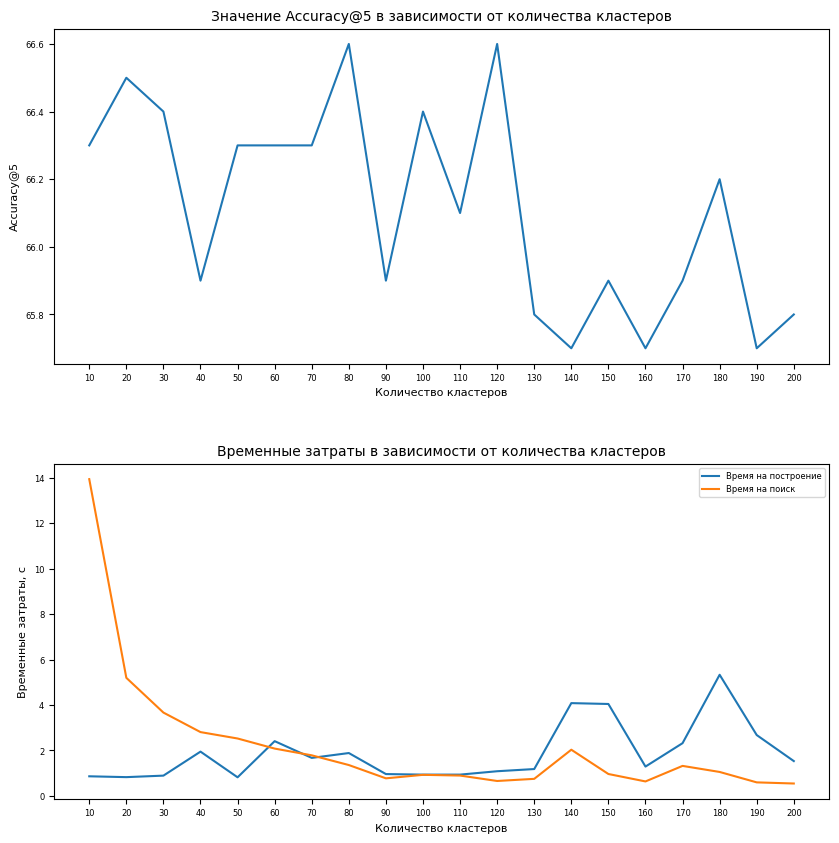

In [ ]:
grafs(m_clusters)

Превысить значение метрики, полученной при расчете евклидового расстояния на 100 кластерах, нам не удалось, однако время на поиск здесь ниже. Сохраним результат с лучшей метрикой и минимальным временем в общую таблицу результатов.

In [ ]:
mips_res = m_clusters[m_clusters['Accuracy@5'] == m_clusters['Accuracy@5'].max()]
mips_res = mips_res[mips_res['Время на поиск'] == mips_res['Время на поиск'].min()]
mips_res.insert(0, 'Алгоритм поиска', ['IVFFlat с косинусным расстоянием'])
results = pd.concat([results, mips_res]).reset_index(drop=True)
display(results)

,Алгоритм поиска,Количество кластеров,Accuracy@5,Время на построение,Время на поиск
0,IVFFlat с евклидовым расстоянием,1,79.5,1.107901,105.697187
1,IVFFlat с евклидовым расстоянием,100,68.1,2.213869,0.800903
2,IVFFlat с косинусным расстоянием,120,66.6,1.084929,0.656083


#### IVFFlat с расстоянием Махаланобиса

В рамках индекса IVFFlat попробуем еще один вариант - расчет расстояния Махаланобиса. Сразу же осуществим перебор количества кластеров от 10 до 200 с шагом 10.

In [ ]:
start = time.perf_counter()
dims = base.shape[1]

base_scalled, train_scalled = scaler(base,train)

base_arr = np.ascontiguousarray(base_scalled).astype('float32')
train_arr = np.ascontiguousarray(train_scalled).astype('float32')

quantizer = faiss.IndexFlatL2(dims)

base_c = base_arr - base_arr.mean(0)
cov = np.dot(base_c.T, base_c) / base_c.shape[0]

L = np.linalg.cholesky(cov)
mahalanobis_transform = np.linalg.inv(L)

def inverse_cholesky_cov(df, mahalanobis_transform):
  df_trans = np.dot(df, mahalanobis_transform.T)
  return df_trans.astype('float32')

base_arr = inverse_cholesky_cov(base_arr, mahalanobis_transform)
train_arr = inverse_cholesky_cov(train_arr, mahalanobis_transform)
mah_time = time.perf_counter() - start

ns = []
accs = []
t_create = []
t_search = []

for n in range(10,210,10):
  start = time.perf_counter()
  mah_index = faiss.IndexIVFFlat(quantizer, dims, n, faiss.METRIC_L2)

  mah_index.train(base_arr)
  mah_index.add(base_arr)
  create_time = time.perf_counter() - start + mah_time

  start = time.perf_counter()
  candidate_number = 5
  r, idx = mah_index.search(train_arr, candidate_number)
  search_time = time.perf_counter() - start

  ns.append(str(n))
  accs.append(acc5(targets, idx, base_index))
  t_create.append(create_time)
  t_search.append(search_time)

mah_clusters = pd.DataFrame(zip(ns, accs, t_create, t_search),
                            columns=('Количество кластеров', 'Accuracy@5', 'Время на построение', 'Время на поиск'))

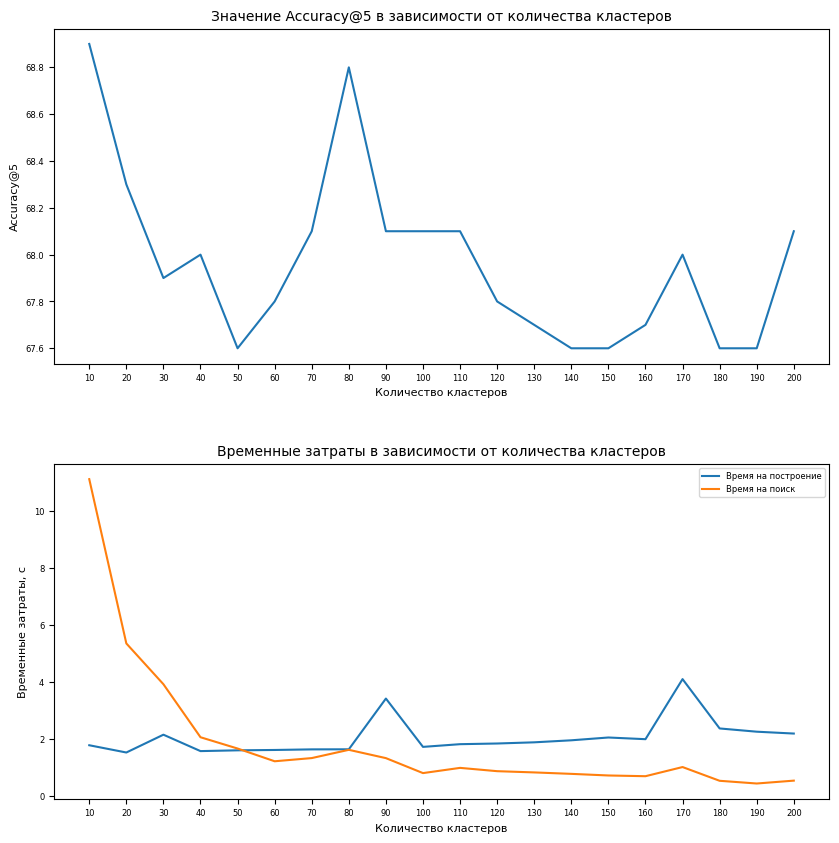

In [ ]:
grafs(mah_clusters)

Качество выше, чем для IVFFlat с евклидовым расстоянием, есть скачок метрики на 80 кластерах, при этом затраты времени небольшие.  

Проверим результат на количестве кластеров от 1 до 9. Да, временные затраты тут будут значительные, однако нам важно выяснить, на сколько можно повысить метрику, в том числе и при полном переборе.

In [ ]:
ns2 = []
accs2 = []
t_create2 = []
t_search2 = []

for n in range(1,10,1):
  start = time.perf_counter()
  mah_index = faiss.IndexIVFFlat(quantizer, dims, n, faiss.METRIC_L2)

  mah_index.train(base_arr)
  mah_index.add(base_arr)
  create_time = time.perf_counter() - start + mah_time

  start = time.perf_counter()
  candidate_number = 5
  r, idx = mah_index.search(train_arr, candidate_number)
  search_time = time.perf_counter() - start

  ns2.append(str(n))
  accs2.append(acc5(targets, idx, base_index))
  t_create2.append(create_time)
  t_search2.append(search_time)

mah_clusters2 = pd.DataFrame(zip(ns2, accs2, t_create2, t_search2),
                             columns=('Количество кластеров', 'Accuracy@5', 'Время на построение', 'Время на поиск'))
mah = pd.concat([mah_clusters, mah_clusters2])

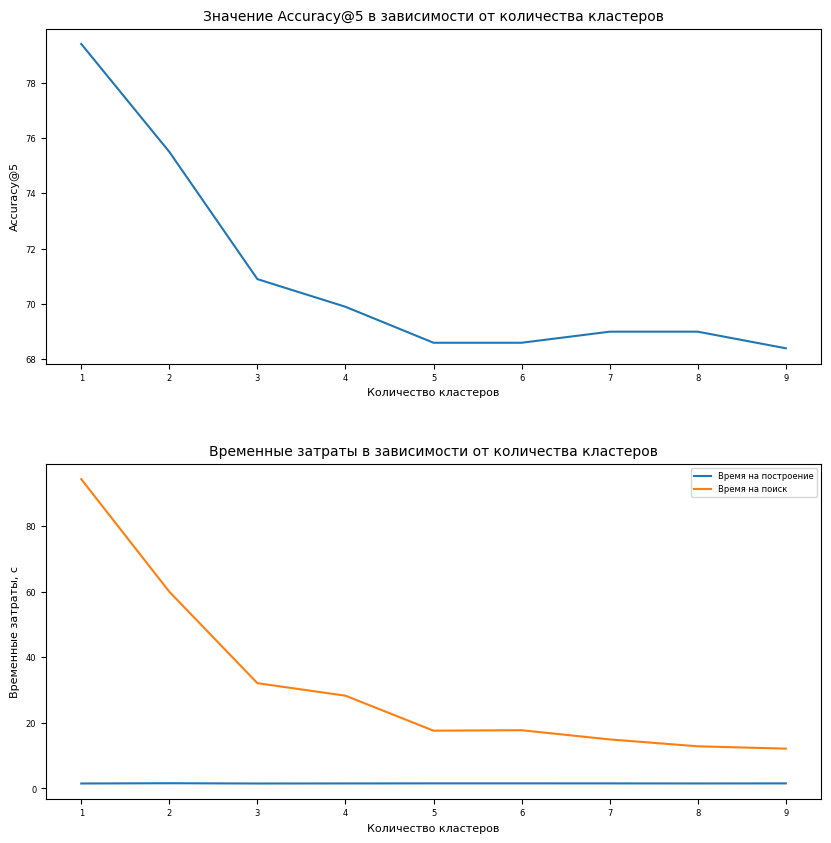

In [ ]:
grafs(mah_clusters2)

На малом количестве кластеров не удалось превысить метрику IVFFlat с евклидовым расстоянием. Сохраним в общую таблицу лучшую метрику на малом количестве кластеров, а также решение при 80 кластерах.

In [ ]:
mah_res1 = mah[mah['Количество кластеров'] == '1']
mah_res2 = mah[mah['Количество кластеров'] == '80']
mah = pd.concat([mah_res1, mah_res2])
mah.insert(0, 'Алгоритм поиска', ['IVFFlat с расстоянием Махаланобиса', 'IVFFlat с расстоянием Махаланобиса'])
results = pd.concat([results, mah]).reset_index(drop=True)
display(results)

,Алгоритм поиска,Количество кластеров,Accuracy@5,Время на построение,Время на поиск
0,IVFFlat с евклидовым расстоянием,1,79.5,1.107901,105.697187
1,IVFFlat с евклидовым расстоянием,100,68.1,2.213869,0.800903
2,IVFFlat с косинусным расстоянием,120,66.6,1.084929,0.656083
3,IVFFlat с расстоянием Махаланобиса,1,79.4,1.517822,94.382007
4,IVFFlat с расстоянием Махаланобиса,80,68.8,1.647288,1.629058


#### Faiss с HNSW

Еще одним решением, которое мы попробуем, будет поиск по графам при помощи индекса HNSW. У данного алгоритма есть 3 гиперпараметра, которые значительно влияют на поиск:  
- M - количество связей между элементами  
- ef_construction - размер списка элементов, используемого при построении индекса  
- ef_search - размер списка элементов, используемого в процессе поиска  

Переберем значения данных гиперпараметров в следующих диапазонах: ef_construction - 64, 128 и 256, M - 16, 32 и 64, при этом не более значения ef_construction, ef_search - 32, 64 и 128, при этом менее значения ef_construction.

In [ ]:
ns = []
accs = []
t_create = []
t_search = []

for i in [64, 128, 256]:
  for k in [16, 32, 64]:
    if k > i:
      break
    else:
      for l in [32,64,128]:
        if l >= i:
          break
        else:
          ef_construction = i
          M = k
          ef_search = l

          start = time.perf_counter()
          base_scalled, train_scalled = scaler(base,train)
          hnsw_index = faiss.IndexHNSWFlat(dims, M)
          hnsw_index.hnsw.efConstruction = ef_construction
          hnsw_index.add(np.ascontiguousarray(base_scalled).astype('float32'))
          create_time = time.perf_counter() - start

          start = time.perf_counter()
          candidate_number = 5
          hnsw_index.hnsw.efSearch = ef_search
          r, idx = hnsw_index.search(np.ascontiguousarray(train_scalled).astype('float32'), candidate_number)
          search_time = time.perf_counter() - start

          ns.append(f'{i},{k},{l}')
          accs.append(acc5(targets, idx, base_index))
          t_create.append(create_time)
          t_search.append(search_time)

params = pd.DataFrame(zip(ns, accs, t_create, t_search),
                            columns=('Значения ef_construction, M и ef_search', 'Accuracy@5', 'Время на построение', 'Время на поиск'))

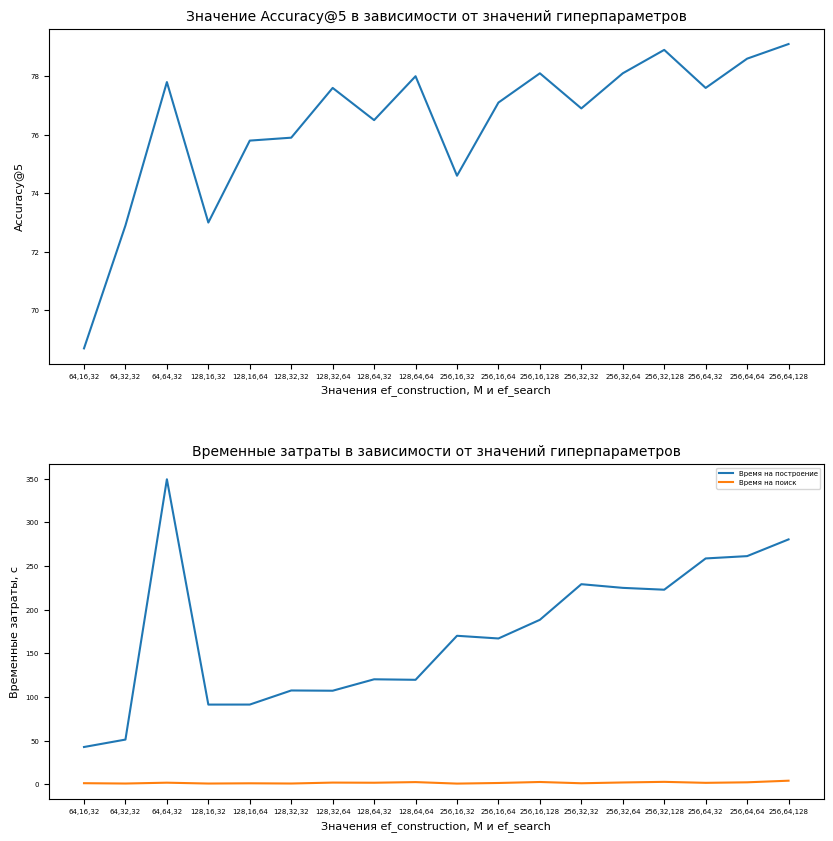

In [ ]:
params.sort_values(by='Accuracy@5')
plt.rc('font', size=5)
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10,10))
plt.subplots_adjust(wspace=0.3, hspace=0.3)
axes[0].plot(params['Значения ef_construction, M и ef_search'], params['Accuracy@5'])
axes[1].plot(params['Значения ef_construction, M и ef_search'], params['Время на построение'])
axes[1].plot(params['Значения ef_construction, M и ef_search'], params['Время на поиск'])
axes[0].set_title('Значение Accuracy@5 в зависимости от значений гиперпараметров', fontsize=10)
axes[1].set_title('Временные затраты в зависимости от значений гиперпараметров', fontsize=10)
axes[1].legend(['Время на построение', 'Время на поиск'])
axes[0].set_ylabel('Accuracy@5', fontsize=8)
axes[1].set_ylabel('Временные затраты, с', fontsize=8)
axes[0].set_xlabel('Значения ef_construction, M и ef_search', fontsize=8)
axes[1].set_xlabel('Значения ef_construction, M и ef_search', fontsize=8)
plt.show()
None

С увеличением значений гиперпараметров растет и качество, наблюдаются провалы только в отдельных точках. При этом временные затраты кардинально отличаются от того, что мы видели при работе с индексом IVFFlat. Если там основное время тратилось на поиск, то в HNSW очень много времени занимает подготовка индекса и построение графов, в то время как непосредственно сам поиск занимает считанные секунды. Посмотрим детальную таблицу с результатами работы HNSW и выберем лучшее решение.

In [ ]:
params

,"Значения ef_construction, M и ef_search",Accuracy@5,Время на построение,Время на поиск
0,"64,16,32",68.7,42.624772,1.162810
1,"64,32,32",72.9,51.140619,0.783419
2,"64,64,32",77.8,349.400324,1.744603
3,"128,16,32",73.0,91.221804,0.763539
4,"128,16,64",75.8,91.255042,1.046340
5,"128,32,32",75.9,107.394192,0.795275
6,"128,32,64",77.6,107.105546,1.857803
7,"128,64,32",76.5,120.203038,1.691191
8,"128,64,64",78.0,119.620827,2.413807
9,"256,16,32",74.6,170.060636,0.700758


Лучшим решением предлагаю считать ef_construction = 256, M = 64 и ef_search = 64. Здесь одна из самых высоких метрик, при этом не самое высокое время работы.

In [ ]:
hnsw_result = params.loc[params['Значения ef_construction, M и ef_search'] == '256,64,64']
hnsw_result.insert(0, 'Алгоритм поиска', ['HNSW'])

#### HNSW с IVF

HNSW показал нам высокое качество, однако не самую лучшую скорость работы. Попробуем оптимизировать его при помощи IVF. Здесь также будут 3 гиперпараметра: уже знакомый нам ef_search, n (количество кластеров) и n_probe (количество пройденных кластеров во время запроса поиска). ef_search установим равным лучшему значению, полученному на предыдущем шаге, n переберем в диапазоне от 50 до 200 с шагом 50, а для n_probe переберем значения 8, 16 и 32.

In [ ]:
ns = []
accs = []
t_create = []
t_search = []
ef_search = 64

for n in range(50,201,50):
  for p in [8,16,32]:
    start = time.perf_counter()
    base_scalled, train_scalled = scaler(base,train)
    index_ivf_hnsw = faiss.index_factory(dims,(f'IVF{n}_HNSW'+ f'{ef_search}'+',Flat'))
    index_ivf_hnsw.nprobe = p
    index_ivf_hnsw.train(np.ascontiguousarray(base_scalled).astype('float32'))
    index_ivf_hnsw.add(np.ascontiguousarray(base_scalled).astype('float32'))
    create_time = time.perf_counter() - start

    start = time.perf_counter()
    candidate_number = 5
    r, idx = index_ivf_hnsw.search(np.ascontiguousarray(train_scalled).astype('float32'), candidate_number)
    search_time = time.perf_counter() - start

    ns.append(f'{n},{p}')
    accs.append(acc5(targets, idx, base_index))
    t_create.append(create_time)
    t_search.append(search_time)

params2 = pd.DataFrame(zip(ns, accs, t_create, t_search),
                            columns=('Количество кластеров и значение nprobe', 'Accuracy@5', 'Время на построение', 'Время на поиск'))

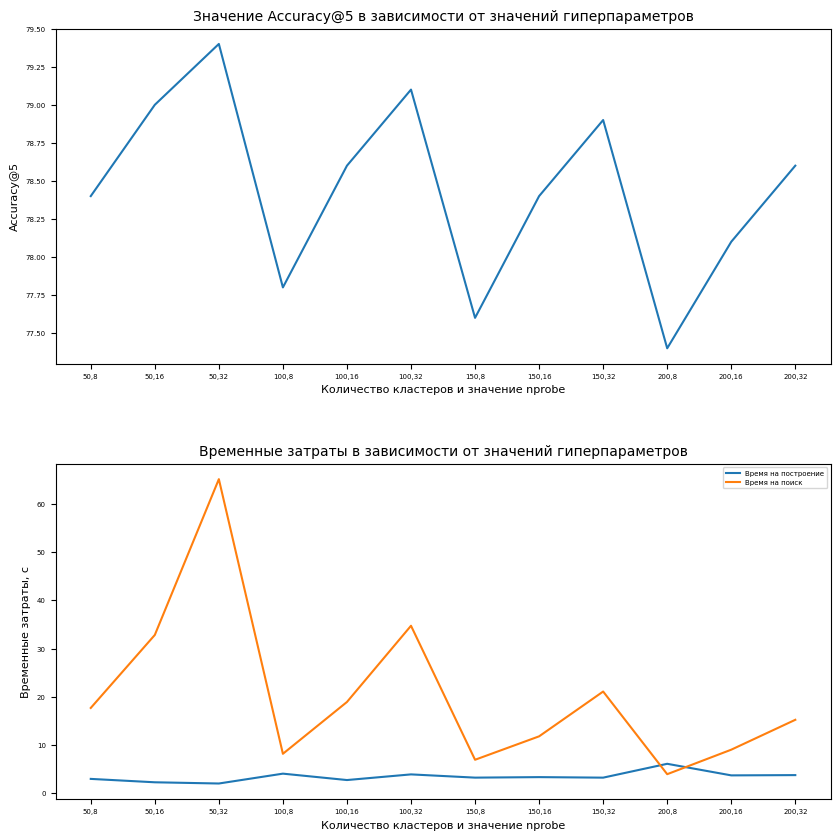

In [ ]:
params2.sort_values(by='Accuracy@5')
plt.rc('font', size=5)
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10,10))
plt.subplots_adjust(wspace=0.3, hspace=0.3)
axes[0].plot(params2['Количество кластеров и значение nprobe'], params2['Accuracy@5'])
axes[1].plot(params2['Количество кластеров и значение nprobe'], params2['Время на построение'])
axes[1].plot(params2['Количество кластеров и значение nprobe'], params2['Время на поиск'])
axes[0].set_title('Значение Accuracy@5 в зависимости от значений гиперпараметров', fontsize=10)
axes[1].set_title('Временные затраты в зависимости от значений гиперпараметров', fontsize=10)
axes[1].legend(['Время на построение', 'Время на поиск'])
axes[0].set_ylabel('Accuracy@5', fontsize=8)
axes[1].set_ylabel('Временные затраты, с', fontsize=8)
axes[0].set_xlabel('Количество кластеров и значение nprobe', fontsize=8)
axes[1].set_xlabel('Количество кластеров и значение nprobe', fontsize=8)
plt.show()
None

Графики очень показательны. С увеличением n_probe растут качество и время, а с увеличением количества кластеров - показатели снижаются. В качестве лучшего выберем решение при на 100 кластеров и n_probe равным 32 - здесь метрика свыше 79, при этом время на самое высокое.

In [ ]:
ivf_hnsw_result = params2.loc[params2['Количество кластеров и значение nprobe'] == '100,32']
ivf_hnsw_result.insert(0, 'Алгоритм поиска', ['HNSW с IVF'])
ivf_hnsw_result

,Алгоритм поиска,Количество кластеров и значение nprobe,Accuracy@5,Время на построение,Время на поиск
5,HNSW с IVF,"100,32",79.1,3.910336,34.734554


Мы попробовали несколько разных алгоритмов поиска и подобрали гиперпараметры. Выберем лучшее решение

### Выбор лучшего решения

In [ ]:
print('Лучшие решения для индекса IVFFlat')
display(results)
print()
print('Лучшее решение для индекса HNSW')
display(hnsw_result)
print()
print('Лучшее решение для HNSW с IVF')
display(ivf_hnsw_result)

Лучшие решения для индекса IVFFlat


,Алгоритм поиска,Количество кластеров,Accuracy@5,Время на построение,Время на поиск
0,IVFFlat с евклидовым расстоянием,1,79.5,1.107901,105.697187
1,IVFFlat с евклидовым расстоянием,100,68.1,2.213869,0.800903
2,IVFFlat с косинусным расстоянием,120,66.6,1.084929,0.656083
3,IVFFlat с расстоянием Махаланобиса,1,79.4,1.517822,94.382007
4,IVFFlat с расстоянием Махаланобиса,80,68.8,1.647288,1.629058



Лучшее решение для индекса HNSW


,Алгоритм поиска,"Значения ef_construction, M и ef_search",Accuracy@5,Время на построение,Время на поиск
16,HNSW,"256,64,64",78.6,261.322954,2.17412



Лучшее решение для HNSW с IVF


,Алгоритм поиска,Количество кластеров и значение nprobe,Accuracy@5,Время на построение,Время на поиск
5,HNSW с IVF,"100,32",79.1,3.910336,34.734554


Лучшим предлагаю считать HNSW c IVF. Здесь одна из самых высоких метрик, при этом не самое большое время выполнения.  

Для дальнейшей работы обернем данное решение в функцию.

In [ ]:
def ivf_hnsw_create(base, n, ef_search, nprobe):
  dims = base.shape[1]
  scaler = StandardScaler()
  base_scalled = scaler.fit_transform(base)
  index_ivf_hnsw = faiss.index_factory(dims,(f'IVF{n}_HNSW'+ f'{ef_search}'+',Flat'))
  index_ivf_hnsw.nprobe = nprobe
  index_ivf_hnsw.train(np.ascontiguousarray(base_scalled).astype('float32'))
  index_ivf_hnsw.add(np.ascontiguousarray(base_scalled).astype('float32'))
  return scaler, index_ivf_hnsw

def ivf_hnsw_search(query, index_ivf_hnsw, scaler, c_number):
    query_scalled = scaler.transform(query)
    candidate_number = c_number
    return index_ivf_hnsw.search(np.ascontiguousarray(query_scalled).astype('float32'), candidate_number)

Мы готовы к проверке на тестовой выборке.

### Проверка лучших решений на тестовой выборке

Подготовим тестовые выборки. Удалим из validation лишние признаки, а столбец Expected из validation_answer превратим в Series для работы с функцией расчета метрики.

In [ ]:
validation.drop(columns=['21', '25', '33', '59', '65', '70'],axis=1, inplace=True)
val_targets = validation_answer['Expected']

Проверим решение.

In [ ]:
start = time.perf_counter()
scaler, index_ivf_hnsw = ivf_hnsw_create(base, 100, 64, 32)
create_time = time.perf_counter() - start
start = time.perf_counter()
r, idx = ivf_hnsw_search(validation, index_ivf_hnsw, scaler, 5)
search_time = time.perf_counter() - start
print('Accuracy@5 на тестовой выборке: ', acc5(val_targets, idx, base_index))
print('Время на построение индекса: ', round(create_time, 2))
print('Время на поиск: ', round(search_time, 2))

Accuracy@5 на тестовой выборке:  78.4
Время на построение индекса:  2.89
Время на поиск:  33.74


Качество незначительно снизилось, однако по-прежнему очень высокое. Общее время на построение индекса и поиск - менее 1 минуты.

## Использование лучших решений на полных выборках

Проверим, как наш алгоритм будет работать на полных выборках. Как мы помним, полные выборки в 10 раз больше сокращенных.  

Для начала удалим из всех выборок лишние признаки и сохраним Target из тренировочной и Expected из тестовой в отдельные переменные для расчета метрики.

In [ ]:
full_base.drop(columns=['21', '25', '33', '59', '65', '70'],axis=1, inplace=True)
full_train.drop(columns=['21', '25', '33', '59', '65', '70'],axis=1, inplace=True)
full_validation.drop(columns=['21', '25', '33', '59', '65', '70'],axis=1, inplace=True)
targets = full_train["Target"]
full_train.drop("Target", axis=1, inplace=True)
val_targets = full_validation_answer['Expected']

Проверим найденное решение на полной тренировочной выборке

In [ ]:
full_base_index = {k: v for k, v in enumerate(full_base.index.to_list())}
scaler, index_ivf_hnsw = ivf_hnsw_create(full_base, 100, 64, 32)
r, idx = ivf_hnsw_search(full_train, index_ivf_hnsw, scaler, 5)
print('Accuracy@5 на полной тренировочной выборке: ', acc5(targets, idx, full_base_index))


Accuracy@5 на полной тренировочной выборке:  71.0


По сравнению с сокращенной выборкой значение метрики снизилось, однако, по-прежнему высоко. Проверим алгоритм на тестовой выборке.

In [ ]:
r, idx = ivf_hnsw_search(full_validation, index_ivf_hnsw, scaler, 5)
print('Accuracy@5 на полной тестовой выборке: ', acc5(val_targets, idx, full_base_index))


Accuracy@5 на полной тестовой выборке:  70.9


Примерно такой же результат. Таким образом, наше решение прошло проверку.

## Итоговый вывод

Целью проекта было разработать алгоритм, который для каждого предложенного в тестовой выборке товара подберет 5 рекомендаций похожих товаров.

Качество работы алгоритма оценивалось при помощи метрики Accuracy@5. Она рассчитывалась следующим образом. Каждый товар в тестовой выборке размечен экспертами - они подобрали для него 1 идеальную рекомендацию. Разработанный алгоритм должен подбирать 5 рекомендаций так, чтобы в них попал товар, выбранный экспертами. Если рекомендация, отмеченная экспертами, попала в 5 рекомендаций, выбранных алгоритмом, accuracy для данного наблюдения будет равно 1, в противном случае - 0. Итоговое значение метрики - среднее по всем товарам в тестовой выборке. Желаемое значение accuracy@5 - не менее 66%.  

**Исходные данные**  

Для проведения исследования нам были предоставлены 4 выборки:   
- base. Общий список товаров с их характеристиками;  
- train. Тренировочная выборка. Товары с разметкой экспертов, на которых необходимо разработать алгоритм. Размер выборки составляет около 10% от base;  
- validation. Тестовая выборка. Товары, на которых необходимо проверить работку итогового алгоритма. Размер выборки также около 10% от base;  
- validation_answer. Товары, рекомендованные экспертами для каждого товара из validation. Иначе говоря, 'правильные ответы'.  

Каждая выборка представлена в 2 версиях - полной и сокращенной. Каждая сокращенная выборка состоит из 10% записей соответствующей полной выборки.  

Следует отметить, что размер полных выборок очень большой. В полной base содержится 2 918 139 уникальных товаров. В связи с чем разрабокта алгоритма производилась на сокращенных выборках, а финальный результат тестировался на полных.  

Также важной особенностью выборок является то, что все признаки в них анонимизированы и представлены в числовой формате. При этом среди значений признаков встречаются дробные и отрицательные значения, что может свидетельствовать о том, что это не реальные значения, а результаты кодирования либо некие расчетные коэффициенты.  

Пропуски в данных отсутствуют, однако во всех сокращенных выборках были обнаружены полные дубли - перед разработкой алгоритма мы их удалили.  

**Разработка алгоритма поиска рекомендаций**  

Для разработки алгоритма использована библиотека Faiss.  

Все признаки были предварительно стандартизированы при помощи StandardScaler - среди всех скэйлеров он показал наибольшее значение метрики при проверке на IVFFlat.  

Также из всех датасетов были удалены 6 ненормально распределенных признаков под номерами - 21, 25, 33, 59, 65, 70. Удаление данных признаков повысило целевую метрику почти на 8%.

В рамках Faiss использованы 5 индексов, для каждого из которых осуществлен перебор ряда гиперпараметров:  
- стандартный IVFFlat с евклидовым расстоянием;  
- IVFFlat с косинусным расстоянием;  
- IVFFlat с расстоянием Махаланобиса;  
- индекс HNSW;  
- HNSW с IVF.  

Лучшие решения для каждого из индексов можно увидеть в таблицах ниже (данные приведены для сокращенной тренировочной выборки).


In [ ]:
print('Лучшие решения для индекса IVFFlat')
display(results)
print()
print('Лучшее решение для индекса HNSW')
display(hnsw_result)
print()
print('Лучшее решение для HNSW с IVF')
display(ivf_hnsw_result)

Лучшие решения для индекса IVFFlat


,Алгоритм поиска,Количество кластеров,Accuracy@5,Время на построение,Время на поиск
0,IVFFlat с евклидовым расстоянием,1,79.5,1.107901,105.697187
1,IVFFlat с евклидовым расстоянием,100,68.1,2.213869,0.800903
2,IVFFlat с косинусным расстоянием,120,66.6,1.084929,0.656083
3,IVFFlat с расстоянием Махаланобиса,1,79.4,1.517822,94.382007
4,IVFFlat с расстоянием Махаланобиса,80,68.8,1.647288,1.629058



Лучшее решение для индекса HNSW


,Алгоритм поиска,"Значения ef_construction, M и ef_search",Accuracy@5,Время на построение,Время на поиск
16,HNSW,"256,64,64",78.6,261.322954,2.17412



Лучшее решение для HNSW с IVF


,Алгоритм поиска,Количество кластеров и значение nprobe,Accuracy@5,Время на построение,Время на поиск
5,HNSW с IVF,"100,32",79.1,3.910336,34.734554


В качестве финального решения выбран индекс HNSW с IVF со следующими гиперпараметрами: ef_search = 64, количество кластеров 100, n_probe = 32. Данное решение показало на тренировочной выборке одно из самых высоких значений метрики при относительно скромных временных затратах.  

Итоговое значение метрики Accuracy@5 на сокращенной тестовой выборке при использовании данного алгоритма составило 78.4%, на полной тестовой - 70.9%.

Таким образом, поставленной цели мы добились.  

**Рекомендации**  

Рекомендации будут следующими:  
- при разработке подобных алгоритмов в качестве цели необходимо устанавливать не только значение метрики качества, но и время работы алгоритма. Время должно быть установлено исходя из назначения дальнейшего использования разработанного алгоритма. В ходе работы над проектом мы обратили внимание, что разные индексы тратят разное количество времени на построение и поиск. При этом самые высокие значения метрики в большинстве случаев достигаются за счет решений, требующих значительного общего времени работы кода. Финальное решение проекта представляет собой относительный баланс между качеством и временем. Однако, если заказчику не важно время работы, можно подобрать еще более качественное решение.   
- следует предоставлять больше информации о признаках, содержащихся в датасетах. Исключение 6 ненормально распределенных признаков повысили метрику на 8%, однако данное решение найдено путем перебора. Если бы мы знали, что скрывается за значениями признаков, мы могли бы определить и обработать аномалии и нереалистичные значения, что также повысило бы метрику. Кроме того, мы могли бы разработать новые синтетические признаки, хорошо подходящие для поиска рекомендаций.  
- несмотря на то, что мы искали баланс между качеством и скоростью, финальное решение занимает достаточно большое время при работе с большими объемами данных (от 1 млн строк и выше). Поэтому, если важна скорость работы, потребуется дополнительно использовать системы обработки больших данных.
